# Section 5 - Model Comparison using Pipelines

GridSearchCV reviews the performance of a set range of parameters on a cross-validation basis. This means only a portion of the training data is reviewed at any one time. When filling in the NA values with the mean value or feature selection, however, we considered the whole set of training data.

Hence we took an inconsistent approach in reviewing only a portion of the data when running GridSearchCV, but the full set of data when filling in missing values. We can avoid this inconsistency by building pipelines and making imputations.

## Pandas - Extracting data

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/train.csv')

## Pandas - Cleaning data

We will leave the NA values in the column Age.

In [6]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

age_mean = df['Age'].mean()

from scipy.stats import mode

mode_embarked = mode(df['Embarked'])[0][0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

pd.get_dummies(df['Embarked'], prefix='Embarked').head(10)
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)

df = df.drop(['Sex', 'Embarked'], axis=1)

cols = df.columns.tolist()
cols = [cols[1]] + cols[0:1] + cols[2:]

df = df[cols]

We then review our dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived       891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Gender         891 non-null int64
Embarked_C     891 non-null float64
Embarked_Q     891 non-null float64
Embarked_S     891 non-null float64
dtypes: float64(5), int64(6)
memory usage: 83.5 KB


In [8]:
train_data = df.values

## Scikit-learn - Training the model

### Building pipelines
We now build pipelines to enable us to first impute the mean value of the column Age on the portion of the training data we are considering, scale the data, select the features, and then assess the performance of our tuning parameters with various learning algorithms.

In [10]:
# Building a pipeline for random forest model (rf)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV

scaler = StandardScaler()
anova_filter = SelectKBest(f_regression)
imputer = Imputer(strategy='mean', missing_values="NaN")
clf = RandomForestClassifier()

pipeline_rf = Pipeline([
    ('imp', imputer),
    ('anova', anova_filter),
    ('rf', clf)
])

# Building a pipeline for SVM classification model (svc)
# Normalisation is important to SVM, unlike for decision tree learning. 

# ANOVA SVM-C
clf = SVC(kernel='rbf')
pipeline_svm = Pipeline([
        ('imp', imputer),
        ('scale', scaler), 
        ('anova', anova_filter), 
        ('svc', clf)
])


### Grid search using pipelines

We now setup parameter grid and run GridSearchCV as before but replacing the classifier with our pipeline.

In [11]:
pipeline_dict = {'rf': pipeline_rf, 'svm': pipeline_svm} 
parameter_grid_dict = {}
parameter_grid_dict['rf'] = {
            'anova__k': [8, 9],
            'rf__n_estimators': [100, 1000],
            'rf__max_depth': [5, None],
        }

parameter_grid_dict['svm'] = {
            'anova__k': [6, 9],
            'svc__C': [0.1, 1, 10],
            'svc__gamma': [0.1, 1]
        }

grid_results = {}
for alg in ['rf', 'svm']:
    pipeline = pipeline_dict[alg]
    parameter_grid = parameter_grid_dict[alg]    
    grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, verbose=3)
    grid_search.fit(train_data[0::,2::], train_data[0::,0])

    sorted(grid_search.grid_scores_, key=lambda x: x.mean_validation_score)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    
    grid_results[alg] = grid_search    
    

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=100 ...............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=100, score=0.804469 -   0.9s
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=100 ...............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=100, score=0.810056 -   0.4s
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=100 ...............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=100, score=0.848315 -   0.4s
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=100 ...............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=100, score=0.792135 -   0.5s
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=100 ...............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=100, score=0.858757 -   0.5s
[CV] rf__max_depth=5, anova__k=8, rf__n_estimators=1000 ..............
[CV]  rf__max_depth=5, anova__k=8, rf__n_estimators=1000, score=0.793296 -   3.9s
[CV] rf__max_depth=5, anova

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  1.2min


[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=100, score=0.798883 -   0.5s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=100 ............
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=100, score=0.865169 -   0.5s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=100 ............
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=100, score=0.764045 -   0.4s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=100 ............
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=100, score=0.847458 -   0.5s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=1000 ...........
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=1000, score=0.804469 -   4.2s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=1000 ...........
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=1000, score=0.804469 -   4.2s
[CV] rf__max_depth=None, anova__k=9, rf__n_estimators=1000 ...........
[CV]  rf__max_depth=None, anova__k=9, rf__n_estimators=1000, score=0

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.6min finished


0.822671156004
{'rf__max_depth': 5, 'anova__k': 8, 'rf__n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] svc__gamma=0.1, anova__k=6, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=6, svc__C=0.1, score=0.793296 -   0.0s
[CV] svc__gamma=0.1, anova__k=6, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=6, svc__C=0.1, score=0.804469 -   0.0s
[CV] svc__gamma=0.1, anova__k=6, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=6, svc__C=0.1, score=0.769663 -   0.0s
[CV] svc__gamma=0.1, anova__k=6, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=6, svc__C=0.1, score=0.775281 -   0.0s
[CV] svc__gamma=0.1, anova__k=6, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=6, svc__C=0.1, score=0.790960 -   0.0s
[CV] svc__gamma=1, anova__k=6, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=6, svc__C=0.1, score=0.754190 -   0.1s
[CV] svc__g

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    2.0s


[CV] svc__gamma=0.1, anova__k=9, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=9, svc__C=0.1, score=0.797753 -   0.0s
[CV] svc__gamma=0.1, anova__k=9, svc__C=0.1 ..........................
[CV] . svc__gamma=0.1, anova__k=9, svc__C=0.1, score=0.807910 -   0.0s
[CV] svc__gamma=1, anova__k=9, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=9, svc__C=0.1, score=0.793296 -   0.0s
[CV] svc__gamma=1, anova__k=9, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=9, svc__C=0.1, score=0.759777 -   0.1s
[CV] svc__gamma=1, anova__k=9, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=9, svc__C=0.1, score=0.747191 -   0.0s
[CV] svc__gamma=1, anova__k=9, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=9, svc__C=0.1, score=0.713483 -   0.0s
[CV] svc__gamma=1, anova__k=9, svc__C=0.1 ............................
[CV] ... svc__gamma=1, anova__k=9, svc__C=0.1, score=0.683616 -   0.0s
[CV] s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.8s finished


In [12]:
# Analysis of the grid search results 
for alg in grid_results:
    grid_search = grid_results[alg]
    sorted(grid_search.grid_scores_, key=lambda x: x.mean_validation_score)
    print 'Best accuracy for %s :' % alg
    print(grid_search.best_score_)
    print(grid_search.best_params_)


Best accuracy for rf :
0.822671156004
{'rf__max_depth': 5, 'anova__k': 8, 'rf__n_estimators': 100}
Best accuracy for svm :
0.82379349046
{'svc__gamma': 0.1, 'anova__k': 9, 'svc__C': 1}


Remark:
Univariate ANOVA feature selection doesn't seem to improve the performance for both RF and SVM. 

### Cross-validation to estimate accuracy and AUC using the selected tuning parameters

In [13]:
# Set the parameters of the models to the best ones selected from grid search
pipeline_rf.set_params(anova__k=9, rf__n_estimators=1000, rf__max_depth=5)
pipeline_svm.set_params(anova__k=9, svc__C=1, svc__gamma=0.1)

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('anova', SelectKBest(k=9, score_func=<function f_regression at 0x10a99a140>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Now to compare performance of different models, perform CV using the best hyper-parameters selected using grid search based on the previous pipeline analysis. This time we use two runs of 5-fold CV in order to get more reliable estimate of the performance. 

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKFold

X = train_data[0:, 2:]
y = train_data[0:, 0]

scv1 = SKFold(y=y, n_folds=5, random_state=1234)
scv2 = SKFold(y=y, n_folds=5, random_state=5678)

def getAccAuc(pipeline, X_train, y_train, X_test, y_test):
    """ To calculate accuracy and auc using different training test sets 
    given a predefined modelling pipeline.
    """
    pipeline.fit(X_train, y_train)
    # Get prediction on class label from the model
    y_prediction = pipeline.predict(X_test)
    
    # Get probability or decision function output from the model
    try:
         y_out = pipeline.predict_proba(X_test)[:,1]                     
    except AttributeError:
         print "No probability output, use decision function instead!"
         y_out = pipeline.decision_function(X_test)
    
    acc = np.sum(y_test == y_prediction)*1./len(y_test)
    print "[CV]Prediction accuracy:", acc
    # Compute area under the ROC curve (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, y_out)
    roc_auc = auc(fpr, tpr)
    print("[CV]           AUC:%s"%roc_auc)
    return([acc, roc_auc])


pipeline_dict = {'rf': pipeline_rf, 'svm': pipeline_svm}
acc_dict = {}
auc_dict = {}
for alg in ['rf', 'svm']:  
  pipeline = pipeline_dict[alg]
  mean_acc = 0.0
  mean_auc = 0.0
  all_acc = []
  all_auc = []
  print '--- CV using %s ---' % alg
  
  for scv in [scv1, scv2]:
     for training_set, test_set in scv:
        X_train = X[training_set]
        y_train = y[training_set]
        X_test = X[test_set]
        y_test = y[test_set]

        [acc, roc_auc] = getAccAuc(pipeline, X_train, y_train, X_test, y_test)
    
        all_acc.append(acc)
        all_auc.append(roc_auc)
        acc_dict[alg] = all_acc
        auc_dict[alg] = all_auc
    
  all_acc=np.asarray(all_acc)
  all_auc=np.asarray(all_auc)
  acc_dict[alg] = all_acc
  auc_dict[alg] = all_auc

  # print 95% C.I. for both accuracy and AUC based on CV
  print("Mean Accuracy: %0.3f (+/- %0.3f)" % (all_acc.mean(), all_acc.std() * 1.96))
  print("Mean AUC: %0.3f (+/- %0.3f)" % (all_auc.mean(), all_auc.std() * 1.96))

--- CV using rf ---
[CV]Prediction accuracy: 0.815642458101
[CV]           AUC:0.847957839262
[CV]Prediction accuracy: 0.826815642458
[CV]           AUC:0.819894598155
[CV]Prediction accuracy: 0.831460674157
[CV]           AUC:0.876203208556
[CV]Prediction accuracy: 0.786516853933
[CV]           AUC:0.880147058824
[CV]Prediction accuracy: 0.864406779661
[CV]           AUC:0.908931462493
[CV]Prediction accuracy: 0.798882681564
[CV]           AUC:0.846903820817
[CV]Prediction accuracy: 0.821229050279
[CV]           AUC:0.82279314888
[CV]Prediction accuracy: 0.831460674157
[CV]           AUC:0.874331550802
[CV]Prediction accuracy: 0.786516853933
[CV]           AUC:0.880013368984
[CV]Prediction accuracy: 0.858757062147
[CV]           AUC:0.911090124123
Mean Accuracy: 0.822 (+/- 0.050)
Mean AUC: 0.867 (+/- 0.059)
--- CV using svm ---
No probability output, use decision function instead!
[CV]Prediction accuracy: 0.837988826816
[CV]           AUC:0.835704874835
No probability output, use deci

### Comparison of model performance from CV
We now can start to compare the CV performance for the two type of models: rf and svm using boxplots and one sample (student) t-tests.

=== rf === 
95% C.I. for both accuracy and AUC based on CV for 
[ 0.81564246  0.82681564  0.83146067  0.78651685  0.86440678  0.79888268
  0.82122905  0.83146067  0.78651685  0.85875706]
Mean Accuracy: 0.822 (+/- 0.050)
[ 0.84795784  0.8198946   0.87620321  0.88014706  0.90893146  0.84690382
  0.82279315  0.87433155  0.88001337  0.91109012]
Mean AUC: 0.867 (+/- 0.059)
=== svm === 
95% C.I. for both accuracy and AUC based on CV for 
[ 0.83798883  0.81564246  0.80898876  0.79775281  0.85875706  0.83798883
  0.81564246  0.80898876  0.79775281  0.85875706]
Mean Accuracy: 0.824 (+/- 0.043)
[ 0.83570487  0.85533597  0.8703877   0.81691176  0.89206692  0.83570487
  0.85533597  0.8703877   0.81691176  0.89206692]
Mean AUC: 0.854 (+/- 0.051)


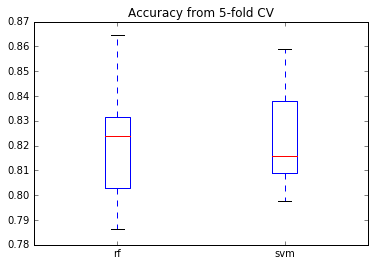

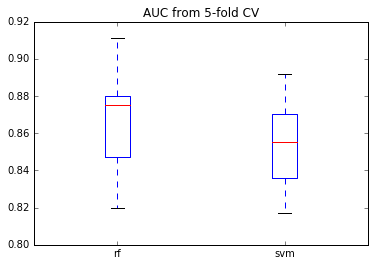

In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
for alg in acc_dict:  
    all_acc = np.array(acc_dict[alg])
    all_auc = np.array(auc_dict[alg])
    print "===", alg, "=== "
    print "95% C.I. for both accuracy and AUC based on CV for "
    print(all_acc)    
    print("Mean Accuracy: %0.3f (+/- %0.3f)" % (all_acc.mean(), all_acc.std() * 1.96))
    print(all_auc)
    print("Mean AUC: %0.3f (+/- %0.3f)" % (all_auc.mean(), all_auc.std() * 1.96))

dfacc = pd.DataFrame(np.c_[acc_dict['rf'], acc_dict['svm']], columns=['rf','svm'])    
dfacc.plot(kind='box', title='Accuracy from 5-fold CV')
dfauc = pd.DataFrame(np.c_[auc_dict['rf'], auc_dict['svm']], columns=['rf','svm'])    
dfauc.plot(kind='box', title='AUC from 5-fold CV')


In [17]:
diff_acc = np.array(acc_dict['rf']) - np.array(acc_dict['svm'])
diff_auc = np.array(auc_dict['rf']) - np.array(auc_dict['svm'])

print 'Test the hypothesis that the mean difference in accuracy between rf and svm is not significantly different from 0:'
print(diff_acc)
print ' Mean difference = %0.3f' % diff_acc.mean()
print(stats.ttest_1samp(diff_acc, popmean=0))
print 'Test the hypothesis that the mean difference in AUC between rf and svm is not significantly different from 0:'
print(diff_auc)
print ' Mean difference = %0.3f' % diff_auc.mean()
print(stats.ttest_1samp(diff_auc, popmean=0))

Test the hypothesis that the mean difference in accuracy between rf and svm is not significantly different from 0:
[-0.02234637  0.01117318  0.02247191 -0.01123596  0.00564972 -0.03910615
  0.00558659  0.02247191 -0.01123596  0.        ]
 Mean difference = -0.002
Ttest_1sampResult(statistic=-0.26758448597885054, pvalue=0.79505037190445593)
Test the hypothesis that the mean difference in AUC between rf and svm is not significantly different from 0:
[ 0.01225296 -0.03544137  0.00581551  0.06323529  0.01686454  0.01119895
 -0.03254282  0.00394385  0.0631016   0.01902321]
 Mean difference = 0.013
Ttest_1sampResult(statistic=1.2313255551089652, pvalue=0.24940567361337934)


Remarks:

1. The mean difference in accuracy and AUC indicates that rf performs slightly better than SVM in auc. The variances in accuracy and AUC for RF are slightly higher than for SVM. And the 95% C.I. of Accuracy for the RF and for SVM indeed overlap, thus the accuracy for RF is not significantly different from SVM (at significance level of 0.05). The same applies to AUC. 

2. The p-value for the one-sample t-test on difference in accuracy is 0.795 >0.05, which reconfirms that we can't reject the null hypothesis that there is no significant difference in accuracy between RF and SVM. 

3. Whilst the p-value for the t-test on difference in AUC is 0.25 > 0.05, thus we can't reject the null hypothesis that there is no significant difference in AUC between RF and SVM. 

More details on how to perform t-tests using scipy, please see: 
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html

## Sikit-learn - Model training
Now that we've determined the model we are going to use and the desired values for our tuning parameters, we can fill in the missing values (NaN) in the column Age with the mean and train our model.

In [18]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [34]:
df['Age'] = df['Age'].fillna(age_mean)

In [35]:
df['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [36]:
train_data = df.values

In [37]:
model = RandomForestClassifier(n_estimators = 1000, max_depth=5)
model = model.fit(train_data[0:,2:],train_data[0:,0])

## Scikit-learn - Making predictions

In [38]:
df_test = pd.read_csv('data/test.csv')

df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

We can fill in the NA values in test data with the mean, since there is no analogous problem of snooping.

In [39]:
df_test['Age'] = df_test['Age'].fillna(age_mean)
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.154603,0.447368,0.392344,35.627188
std,120.810458,0.841838,12.636666,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [40]:
fare_means = df.pivot_table('Fare', index='Pclass', aggfunc='mean')
df_test['Fare'] = df_test[['Fare', 'Pclass']].apply(lambda x:
                            fare_means[x['Pclass']] if pd.isnull(x['Fare'])
                            else x['Fare'], axis=1)

df_test['Gender'] = df_test['Sex'].map({'female': 0, 'male': 1}).astype(int)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], prefix='Embarked')],
                axis=1)

df_test = df_test.drop(['Sex', 'Embarked'], axis=1)

test_data = df_test.values

output = model.predict(test_data[0::,1::])

/Applications/CompTools/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  app.launch_new_instance()


## Pandas - Preparing for submission

In [41]:
result = np.c_[test_data[:,0].astype(int), output.astype(int)]

df_result = pd.DataFrame(result[:,0:2], columns=['PassengerId', 'Survived'])
df_result.to_csv('results/titanic_5.csv', index=False)

## Checking verions

Finally, checking the versions of python and relevant libraries. 

In [42]:
import sys
import sklearn
print 'Python: ', sys.version_info
print 'Pandas: ', pd.__version__
print 'Sklearn: ', sklearn.__version__


Python:  sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)
Pandas:  0.17.1
Sklearn:  0.17
